# IPython Notebook for animation

## Importing the required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output
import  matplotlib.animation as animation

## Set the path/ filename of the file the contains the data

In [2]:
inputfilePath = 'config_output.txt'
obsfilePath = 'obs_output.txt'

## Read the data from the files and save it in lists of floats

In [3]:
e = 1.602176634*1e-19
hbar = 1.054571817*1e-34

plotData = [] #Array to save the real part of the wave functions
with open(inputfilePath,'r') as inputfile:
    for line in inputfile:
        plotData.append(line.strip().split('\t')) #Tab is used as seperator between values
    for j in range(len(plotData)): #Cast list items from string to float type
        plotData[j] = [float(plotData[j][i]) for i in range(len(plotData[0]))] # cast entries to float
    plotData = np.array(plotData) # cast to numpy array
    
obsData = [] # Array to save the observable data
with open(obsfilePath,'r') as obsfile:
    for line in obsfile:
        obsData.append(line.strip().split('\t'))
    for j in range(len(obsData)):
        obsData[j] = [float(obsData[j][i]) for i in range(len(obsData[0]))]
    obsData = np.array(obsData).T

## Generate animation

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


...

ValueError: unknown file extension: .mp4

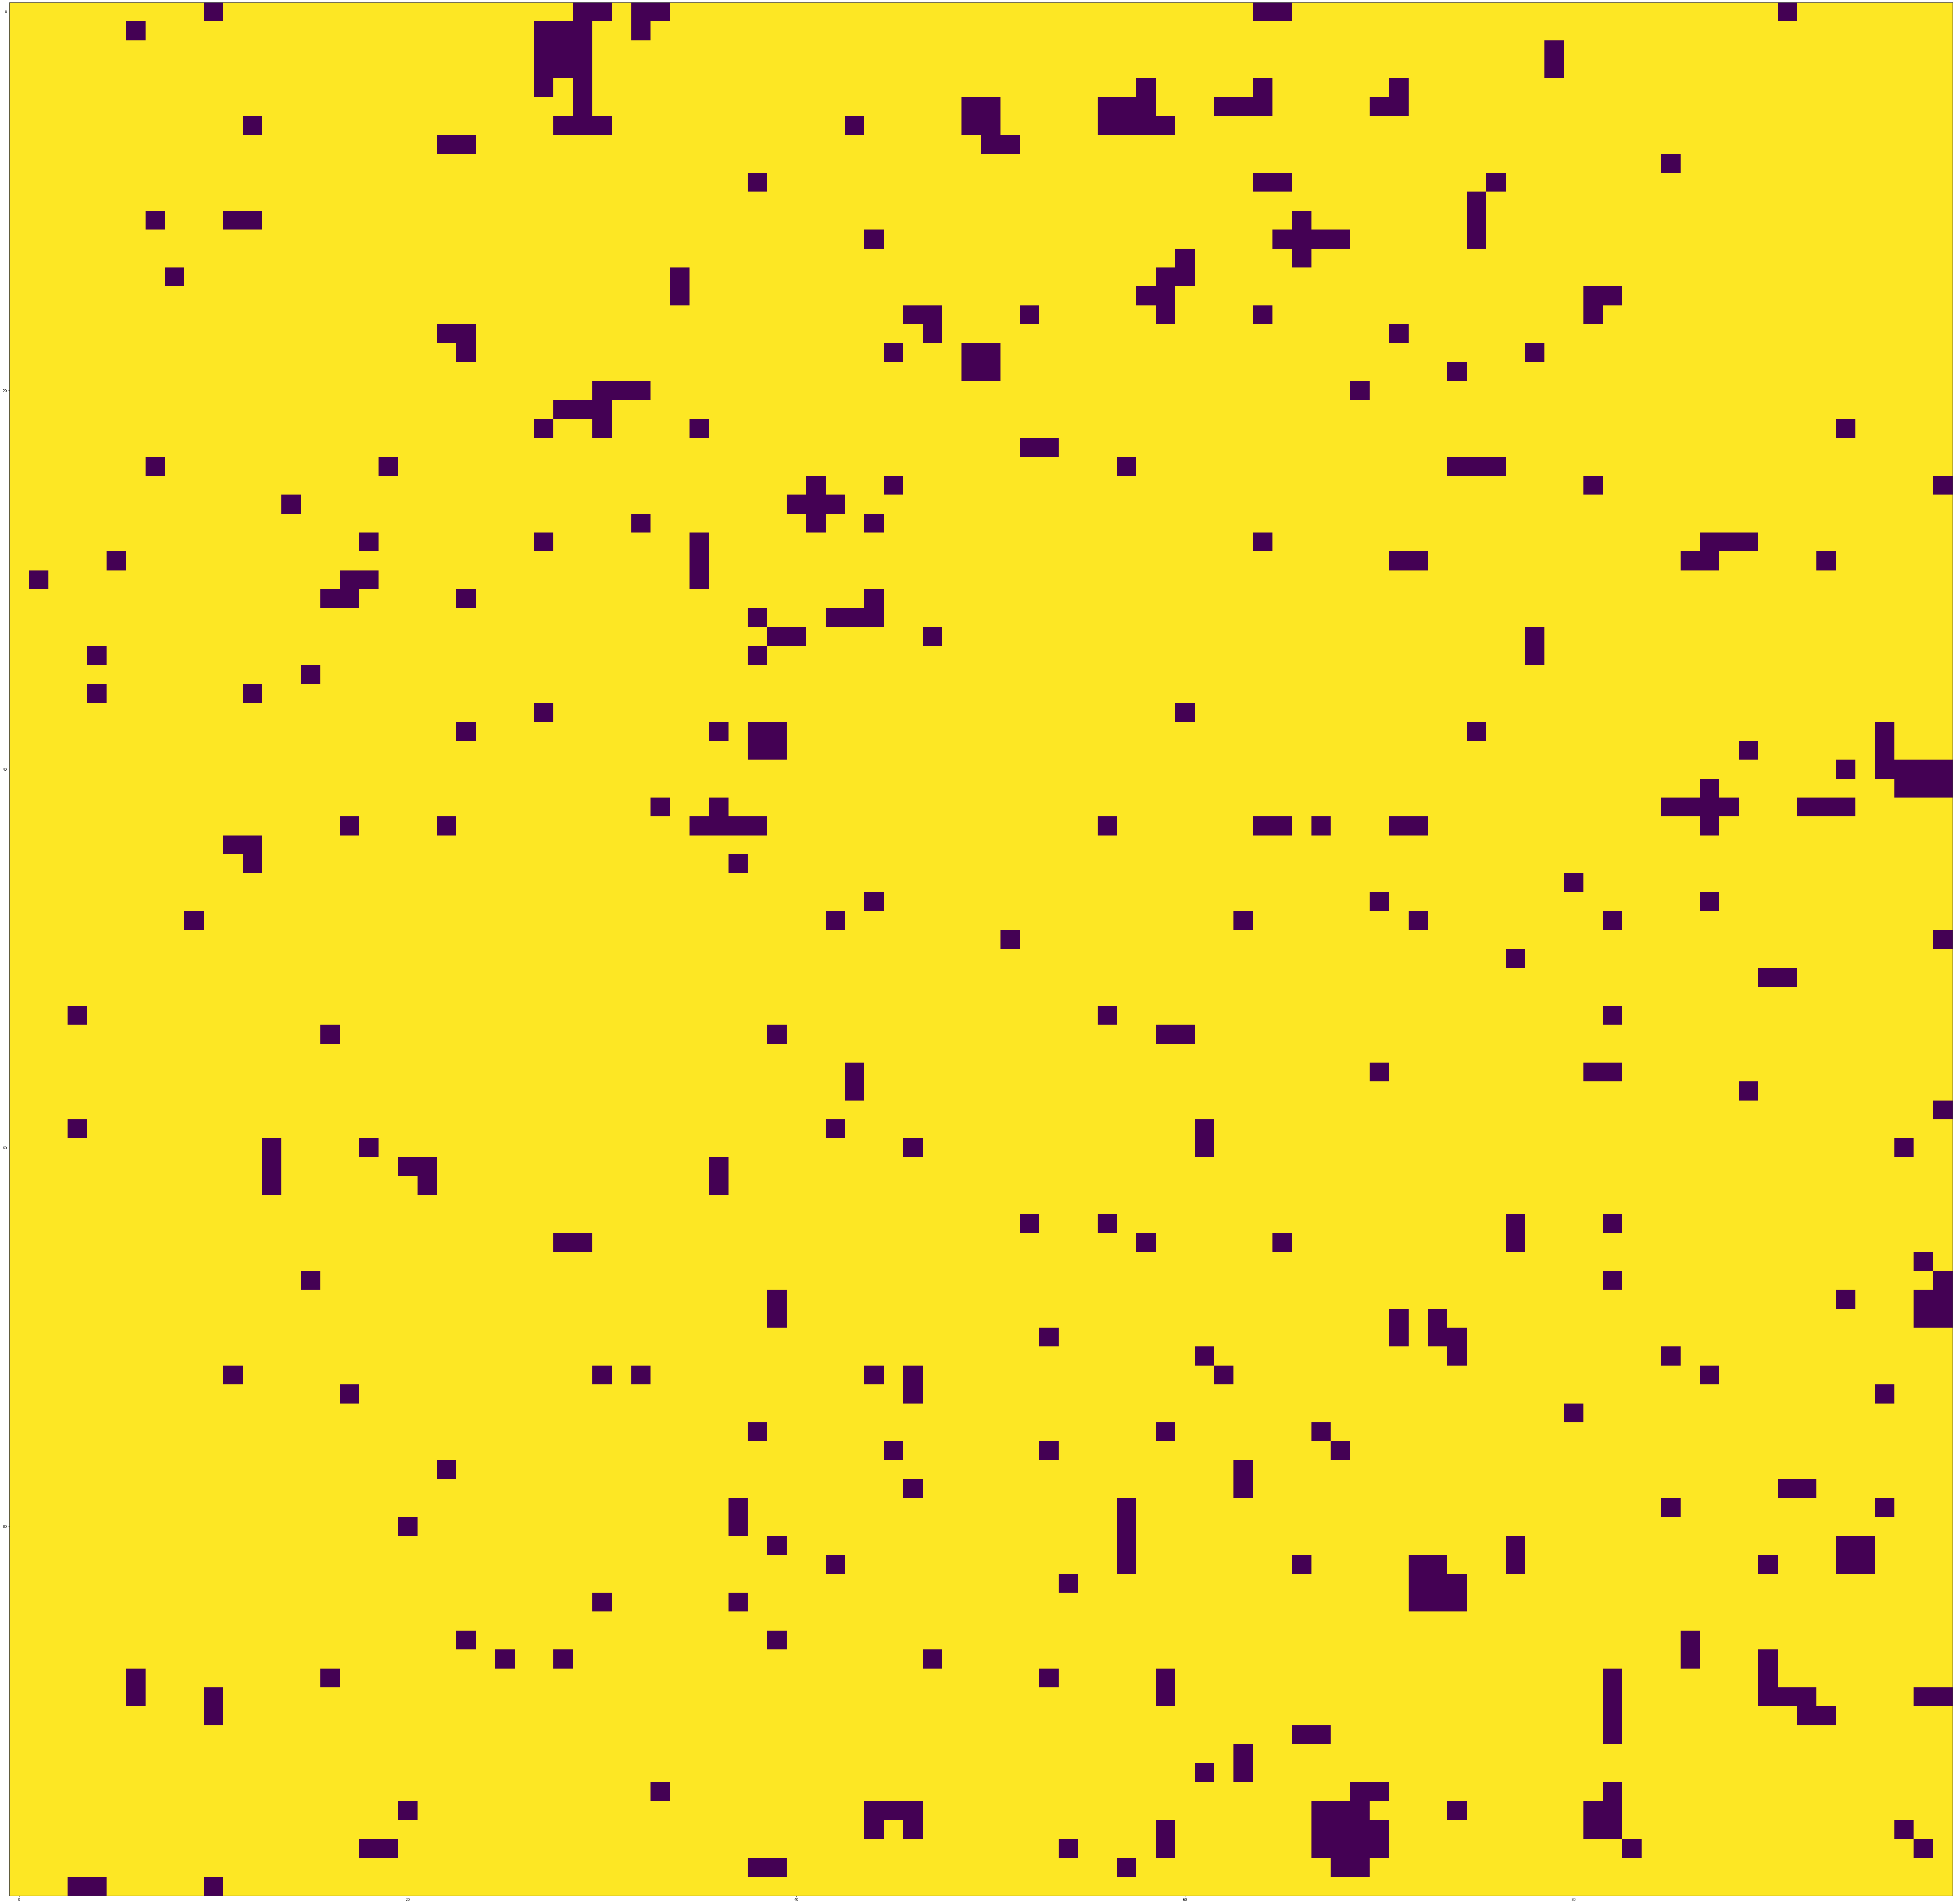

In [8]:
fps = 10
nSeconds = int(len(plotData)/fps)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(100,100) )

plotData = plotData.reshape(len(plotData),100,100)
im = plt.imshow(plotData[0], interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(plotData[i])
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = nSeconds * fps, interval = 1000 / fps)

anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')

## Graphical output of the observables
### Valid values for obs are:
###    - "norm-1"  to display the time evolution of the normalisation minus 1
###    - "energy"  to display the time evolution of the energy expectation value
###    - "x"  to display the time evolution of the spacial coordinate expectation value
###    - "p"  to display the time evoltuion of the momentum expectation value
###    - "delta-x"  to display the width of the wave in real space
###    - "delta-p"  to display the width of the wave in momentum space

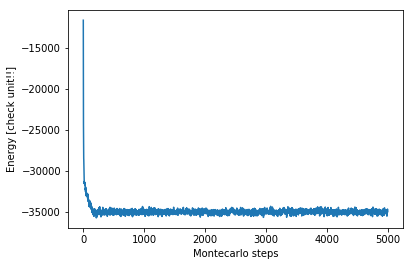

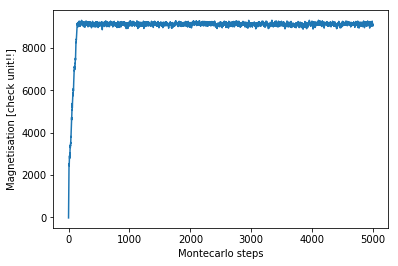

In [4]:
# %matplotlib qt5
n_th = 0

plt.plot(obsData[0][n_th:],obsData[1][n_th:])
plt.xlabel("Montecarlo steps")
plt.ylabel("Energy [check unit!!]")
plt.show()
    
plt.plot(obsData[0][n_th:],obsData[2][n_th:])
plt.xlabel("Montecarlo steps")
plt.ylabel("Magnetisation [check unit!!]")
plt.show()

In [5]:
def auto_corr(obs, N, k):
    res=0
    mu=np.mean(obs)
    for i in range(N-k):
        res+= (obs[i]-mu) * (obs[i+k]-mu)
    return res/(N-k)

In [6]:
def exp_fit(x,a,tau):
    return a*np.exp(-x/tau)

In [7]:
autocorr=[]
Range=np.arange(n_th,len(obsData[0]))
for k in Range:
    autocorr.append(auto_corr(obsData[0][n_th:],len(obsData[0][n_th:]), k))

In [8]:
autocorr

[2083333.25,
 2082499.75,
 2081665.9166666667,
 2080831.75,
 2079997.25,
 2079162.4166666667,
 2078327.25,
 2077491.75,
 2076655.9166666667,
 2075819.75,
 2074983.25,
 2074146.4166666667,
 2073309.25,
 2072471.75,
 2071633.9166666667,
 2070795.75,
 2069957.25,
 2069118.4166666667,
 2068279.25,
 2067439.75,
 2066599.9166666667,
 2065759.75,
 2064919.25,
 2064078.4166666667,
 2063237.25,
 2062395.75,
 2061553.9166666667,
 2060711.75,
 2059869.25,
 2059026.4166666667,
 2058183.25,
 2057339.75,
 2056495.9166666667,
 2055651.75,
 2054807.25,
 2053962.4166666667,
 2053117.25,
 2052271.75,
 2051425.9166666667,
 2050579.75,
 2049733.25,
 2048886.4166666667,
 2048039.25,
 2047191.75,
 2046343.9166666667,
 2045495.75,
 2044647.25,
 2043798.4166666667,
 2042949.25,
 2042099.75,
 2041249.9166666667,
 2040399.75,
 2039549.25,
 2038698.4166666667,
 2037847.25,
 2036995.75,
 2036143.9166666667,
 2035291.75,
 2034439.25,
 2033586.4166666667,
 2032733.25,
 2031879.75,
 2031025.9166666667,
 2030171.75,


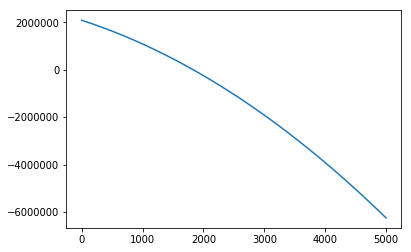

In [9]:
plt.plot(Range,autocorr)
plt.show()